# Анализ журнала обнаружения вторжений

Данный датасет содержит синтетические логи системы обнаружения вторжений, симулирующие нормальную и вредоносную активность за недельный период.

Главные цель данного исследования:
- классифицировать тип запроса: нормальный, сканирование портов или бот-атака.

Задачи:
- провести разведочный анализ данных;
- разделить данные на тренировочную и тестовую выборки;
- при необходимости очистить данные, преобразовать и создать новые признаки;
- на основе имеющихся данных выбрать один или несколько алгоритмов;
- обучить модели на тренировочных данных;
- оценить качество моделей, выбрать среди них наиболее хорошо обобщающую новые данные;
- выпить чашечку чая и завершить свой первый ML-проект на GitHub.

Ссылка: https://www.kaggle.com/datasets/developerghost/intrusion-detection-logs-normal-bot-scan

## Импорт библиотек и модулей

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

## Загрузка данных

In [3]:
logs = pd.read_csv("Network_logs.csv")
print(f"Первые 5 строк датасета:\n\n{logs.head()}\n")
print(f"Последние 5 строк датасета:\n\n{logs.tail()}")

Первые 5 строк датасета:

        Source_IP  Destination_IP  Port Request_Type Protocol  Payload_Size  \
0  192.168.142.55   42.156.67.167    80          FTP      UDP          2369   
1    53.39.165.18   94.60.242.119   135         SMTP      UDP          1536   
2  192.168.127.91      7.10.192.3    21         SMTP      TCP          1183   
3   192.168.30.40  130.169.82.211    25        HTTPS      TCP           666   
4  192.168.43.179  35.140.102.220    22          FTP      TCP          2821   

    User_Agent   Status  Intrusion  Scan_Type  
0  curl/7.68.0  Success          0     Normal  
1  Wget/1.20.3  Failure          1  BotAttack  
2  Wget/1.20.3  Success          0     Normal  
3  Mozilla/5.0  Success          0     Normal  
4  Mozilla/5.0  Success          0     Normal  

Последние 5 строк датасета:

            Source_IP   Destination_IP   Port Request_Type Protocol  \
8841   192.168.62.111    217.201.54.87     22          DNS      UDP   
8842   192.168.154.70    11.93.131.139 

## Разведочный анализ данных
Датасет имеет 8846 строк и 10 столбцов без null-значений, что несколько упрощает очистку датасета. Имеются следующие столбцы:
- Source_IP - IP-адрес источника запроса;
- Destination_IP - IP-адрес получателя запроса;
- Port - Порт;
- Request_Type - Протокол прикладного уровня;
- Protocol - Протокол нижестоящих уровней (Транспортный/сетевой);
- Payload_Size - Нагрузка;
- User_Agent - User-Agent отправителя;
- Status - Статус запроса (Успех/Провал);
- Intrussion - Отметка попытки вторжения;
- Scan_Type - Совершаемое действие (Обычное/Сканирование портов/Атака ботов)

In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source_IP       8846 non-null   object
 1   Destination_IP  8846 non-null   object
 2   Port            8846 non-null   int64 
 3   Request_Type    8846 non-null   object
 4   Protocol        8846 non-null   object
 5   Payload_Size    8846 non-null   int64 
 6   User_Agent      8846 non-null   object
 7   Status          8846 non-null   object
 8   Intrusion       8846 non-null   int64 
 9   Scan_Type       8846 non-null   object
dtypes: int64(3), object(7)
memory usage: 691.2+ KB


Целевой переменной в данном случае является:
- **Scan_Type** - категориальная переменная, классифицирующая нормальный ли был запрос (Normal) или являлся вредоносным (BotAttack/PortScan).

### Проанализируем целевую переменную

Посмотрим на соотношение обычных и вредоносных запросов, на количество успешных и провальных запросов, а также на количество успешных и провальных среди обычных и вредоносных запросов. 

In [5]:
intrusion_counts = logs['Intrusion'].value_counts()
status_counts = logs['Status'].value_counts()

intrusion_statuses = pd.DataFrame()

for i, col_name in enumerate(['Common', 'Malicious']):
    col = logs[(logs['Intrusion'] == i) & ((logs['Status'] == 'Success') | (logs['Status'] == 'Failure'))]
    intrusion_statuses.insert(i, col_name, col['Status'].value_counts())
    
print(f"Соотношение нормальных и вредоносных запросов:\n{intrusion_counts}\n")
print(f"Соотношение успешных и провальных запросов:\n{status_counts}\n")
print(f"Соотношение успешных и провальных нормальных запросов:\n{intrusion_statuses['Common']}\n")
print(f"Соотношение успешных и провальных вредоносных запросов:\n{intrusion_statuses['Malicious']}\n")

Соотношение нормальных и вредоносных запросов:
Intrusion
0    8000
1     846
Name: count, dtype: int64

Соотношение успешных и провальных запросов:
Status
Success    7737
Failure    1109
Name: count, dtype: int64

Соотношение успешных и провальных нормальных запросов:
Status
Success    7615
Failure     385
Name: Common, dtype: int64

Соотношение успешных и провальных вредоносных запросов:
Status
Success    122
Failure    724
Name: Malicious, dtype: int64



В результате видим, что из всего количества запросов:
- 8000 (90,44%) являются нормальными;
- 846 (9,56%) запросов являются вредоносными;
- 7737 (87,46%) являются успешными;
- 1109 (12,54%) являются провальными.

Среди нормальных запросов:
- 7615 (95,19%) являются успешными;
- 385 (4,81%) являются провальными.

Среди вредоносных запросов:
- 122 (14,42%) являются успешными;
- 724 (85,58%) являются провальными.

Какие выводы мы модет из этого сделать:
- Среди обычных запросов большая часть являются успешными, а среди  вредоносных, наоборот, больше провальных запросов.

Построим столбчатую диаграмму для визуализации полученных соотношений.

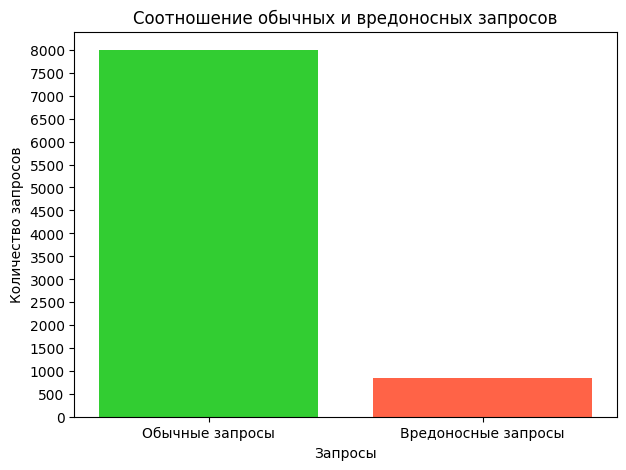

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

ax.bar(['Обычные запросы', 'Вредоносные запросы'], intrusion_counts, 
          color=['limegreen', 'tomato'])
ax.set_yticks(np.arange(0, np.max(intrusion_counts)+500, 500))
ax.set_title('Соотношение обычных и вредоносных запросов')
ax.set_xlabel('Запросы')
ax.set_ylabel('Количество запросов')
plt.show()

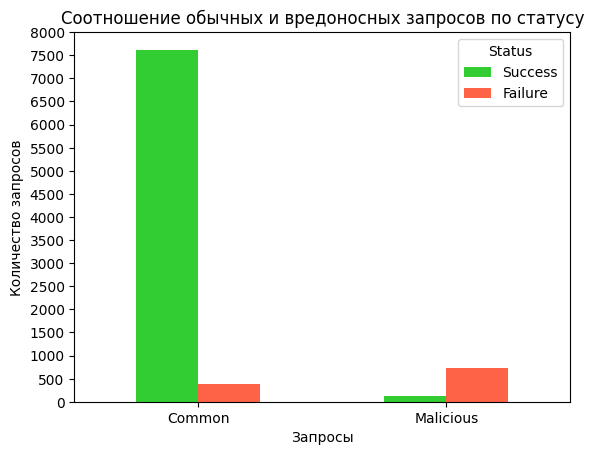

In [9]:
ax = intrusion_statuses.T.plot.bar(rot=0, color=['limegreen', 'tomato'])
ax.set_title('Соотношение обычных и вредоносных запросов по статусу')
ax.set_xlabel('Запросы')
ax.set_ylabel('Количество запросов')
ax.set_yticks(np.arange(0, np.max(intrusion_counts)+500, 500))
plt.show()

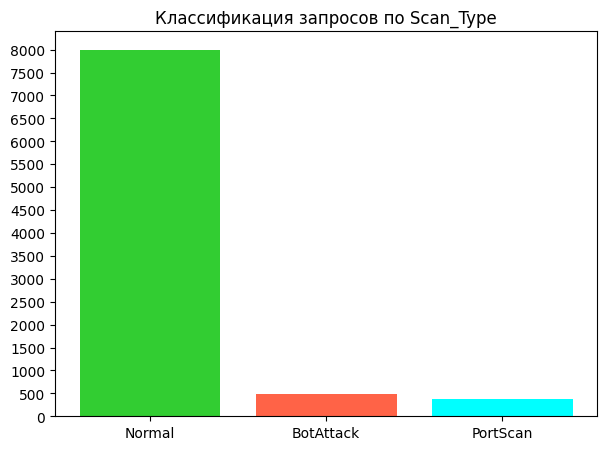

In [11]:
scan_types = logs['Scan_Type'].value_counts()

fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(scan_types.index, scan_types.values, color=['limegreen', 'tomato', 'cyan'])
ax.set_title('Классификация запросов по Scan_Type')
ax.set_yticks(np.arange(0, max(scan_types)+500, 500))
plt.show()

Не лишним будет проверить, нет ли в датасете ошибок, когда признак 'Intrusion' равен 0 (т.е. запрос нормальный), а 'Scan_Type' классифицируется, как BotAttack или PortScan.

In [10]:
print(f"Уникальные значения Scan_Type при Intrusion=0: {logs[logs['Intrusion'] == 0]['Scan_Type'].unique()}")
print(f"Уникальные значения Scan_Type при Intrusion=1: {logs[logs['Intrusion'] == 1]['Scan_Type'].unique()}")

Уникальные значения Scan_Type при Intrusion=0: ['Normal']
Уникальные значения Scan_Type при Intrusion=1: ['BotAttack' 'PortScan']


Следует отметить, что признак Intrusion классифицирует запросы на нормальные и вредоносным. При этом целевая переменная Scan_Type так же классифицирует запросы на нормальные и вредоносные, но более детально. Таким образом, когда признак Intrusion будет равен 1, Scan_Type будет просто классифицировать этот вредоносный запрос. **Это говорит о взаимосвязи признака 'Intrusion' и переменной 'Scan_Type'. Я предполагаю, что добавление признака Intrusion будет являться таргетной утечкой данных, когда в моделировании используются признаки, напрямую или косвенно связанные с целевым признаком. Поэтому признак Intrusion следует удалить.**

### Проанализируем IP-адреса отправителей и получателей.

Сами по себе IP-адреса отправителей не являются ценным признаком по следующим причинам:
- **IP-адрес является просто идентификатором устройства в сети, его случайное значение никак не влияет на признак и характер атаки;**
- **IP-адрес атакующего устройства может быть абсолютно любым;**
- **IP-адреса можно менять.**

По этим причинам нет смысла включать 'Source_IP' в список признаков.

IP-адреса получателей так же не является полезным признаком:
- **Атаки могут происходить на разные ресурсы;**
- **IP-адрес не даёт информации о характере атаки и не может быть использован для прогнозирования;**
- **Единственной полезной информацией может быть количество атак на определённые ресурсы.**

In [11]:
for i in [0, 1]:
    print(f"Количество запросов по IP-адресам с Intrusion={i}:\n{logs[logs['Intrusion']==i]['Source_IP'].value_counts().head(10)}\n")

Количество запросов по IP-адресам с Intrusion=0:
192.168.108.150    3
192.168.91.48      3
192.168.147.188    3
192.168.124.233    3
192.168.86.173     3
192.168.50.207     3
192.168.166.28     3
192.168.231.128    3
192.168.224.142    3
192.168.33.4       3
Name: Source_IP, dtype: int64

Количество запросов по IP-адресам с Intrusion=1:
33.5.52.172        58
154.113.2.100      57
95.139.88.51       57
78.199.98.120      56
197.134.233.238    54
94.40.34.8         48
201.232.85.16      46
216.181.134.4      46
161.77.134.239     45
219.110.174.163    44
Name: Source_IP, dtype: int64



In [12]:
print(f"Наиболее атакуемые ресурсы:\n{logs[logs['Intrusion']==1]['Destination_IP'].value_counts().sort_values(ascending=False)}")

Наиболее атакуемые ресурсы:
94.60.242.119      1
78.142.23.114      1
159.108.69.64      1
171.149.47.196     1
146.171.223.16     1
                  ..
11.88.20.176       1
195.180.238.190    1
211.139.148.189    1
187.227.223.149    1
168.101.218.238    1
Name: Destination_IP, Length: 846, dtype: int64


Как видно, среди адресов назначения не выделяются конкретные IP-адреса, следовательно данный столбец так же не несёт полезной информации.
Оба столбца можно исключить из набора признаков.

### Проанализируем порты, протоколы прикладного, протоколы нижестоящих уровней и User-Agent'ы

Выведем уникальные значения по столбцам для каждого признака. После чего посмотрим на порты, протоколы и user-agents при различных значениях признака запросов: Normal, BotAttack и PortScan.

In [14]:
list_of_features = ['Port', 'Request_Type', 'Protocol', 'User_Agent']

for col in list_of_features:
    print(f"Уникальные значения столбца {col}:\n{logs[col].unique()}\n")

Уникальные значения столбца Port:
[   80   135    21    25    22    53   443  4444  6667    23 31337  8080]

Уникальные значения столбца Request_Type:
['FTP' 'SMTP' 'HTTPS' 'DNS' 'SSH' 'HTTP' 'Telnet']

Уникальные значения столбца Protocol:
['UDP' 'TCP' 'ICMP']

Уникальные значения столбца User_Agent:
['curl/7.68.0' 'Wget/1.20.3' 'Mozilla/5.0' 'Nikto/2.1.6' 'nmap/7.80'
 'python-requests/2.25.1']



In [15]:
for feature in list_of_features:
    normal_values = logs[logs['Scan_Type'] == 'Normal'][feature].unique()
    bot_attack_values = logs[logs['Scan_Type'] == 'BotAttack'][feature].unique()
    port_scan_values = logs[logs['Scan_Type'] == 'PortScan'][feature].unique()
    
    print(f"Значения признака {feature} при Normal: {sorted(normal_values)}")
    print(f"Значения признака {feature} при BotAttack: {sorted(bot_attack_values)}")
    print(f"Значения признака {feature} при PortScan: {sorted(port_scan_values)}\n")

Значения признака Port при Normal: [21, 22, 25, 53, 80, 443]
Значения признака Port при BotAttack: [23, 135, 4444, 6667, 8080, 31337]
Значения признака Port при PortScan: [23, 135, 4444, 6667, 8080, 31337]

Значения признака Request_Type при Normal: ['DNS', 'FTP', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'Telnet']
Значения признака Request_Type при BotAttack: ['DNS', 'FTP', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'Telnet']
Значения признака Request_Type при PortScan: ['DNS', 'FTP', 'HTTP', 'HTTPS', 'SMTP', 'SSH', 'Telnet']

Значения признака Protocol при Normal: ['ICMP', 'TCP', 'UDP']
Значения признака Protocol при BotAttack: ['ICMP', 'TCP', 'UDP']
Значения признака Protocol при PortScan: ['ICMP', 'TCP', 'UDP']

Значения признака User_Agent при Normal: ['Mozilla/5.0', 'Nikto/2.1.6', 'Wget/1.20.3', 'curl/7.68.0', 'nmap/7.80', 'python-requests/2.25.1']
Значения признака User_Agent при BotAttack: ['Mozilla/5.0', 'Nikto/2.1.6', 'Wget/1.20.3', 'curl/7.68.0', 'nmap/7.80', 'python-requests/2.25.1']
Значения п

Из этого мы можем сделать некоторые полезные выводы:
- **Порты при атаке ботов и сканировании портов - одинаковые;**
- **Протоколы и User-Agent'ы при нормальных запросах, атаке ботов и сканировании портов - одинаковые.**

Построим столбчатые диаграммы, показывающие количество запросов и их тип атаки по признакам Request_Type, Protocol и User_Agent.

In [18]:
def create_feature_dict(feature, outcomes):
    """Функция для создания словаря:
    Key - Тип атаки (Normal, BotAttack, PortScan)
    Value - Количество запросов по типу атаки для значений определённого признака
    Например: BotAttack: [10, 22, 12] - количество запросов по протоколу ICMP, TCP, UDP при бот-атаке"""
    
    feature_labels = logs[feature].unique()  # Метки иксов
    feature_labels.sort()  # сортировка меток иксов для схождения с количествами запросов, сортированных по индексу
    request_by_scan_type = {key: None for key in outcomes}  # Словарь исход: количество запросов
    
    for key in request_by_scan_type:
        
        value_counts_list = logs[logs['Scan_Type'] == key][feature].value_counts().sort_index().values  # сортированный по индексу список с количествами запросов
        request_by_scan_type[key] = value_counts_list  # добавляем количество запросов к типу исхода (Normal, BotAttack, PortScan)
        
        #print(f"{key}:{feature_labels}\n{request_by_scan_type[key]}\n")
    
    # print('---')
    
    return request_by_scan_type, feature_labels


def create_bar_plot(request_by_scan_type, feature_labels, feature):
    """Функция для создания столбчатых диаграмм """
    x = np.arange(len(feature_labels))  # позиция протокола на графике
    width = 0.25  # ширина столбца
    multiplier = 0  # множитель столбца
    colors = ['tomato', 'cyan', 'limegreen']
    
    fig, ax = plt.subplots(layout='constrained')
    
    max_count = 0  # Максимальное значение по оси y
    
    for scan_type, counts in request_by_scan_type.items():  # Проходим по типу атаки и количествам запросов по значениям признаков
        if max(counts) > max_count:
            max_count = max(counts)
            
        offset = width * multiplier  # значение, прибавляемое к x для локации столбца
        rects = ax.bar(x + offset, counts, width, label=scan_type, color=colors[multiplier-1])
        ax.bar_label(rects, padding=3)  # добавление значений на вершины столбцов
        multiplier += 1
    
    ax.set_title(f"Количество запросов и их scan_type по признаку {feature}")
    ax.legend(loc='upper right', ncols=3)
    ax.set_xticks(x + width, feature_labels)
    if max_count >= 1800:
        ax.set_yticks(np.arange(0, max_count+400, 200))
        ax.set_ylim(0, max_count+400)
    else:
        ax.set_yticks(np.arange(0, max_count+400, 100))
        ax.set_ylim(0, max_count+200)

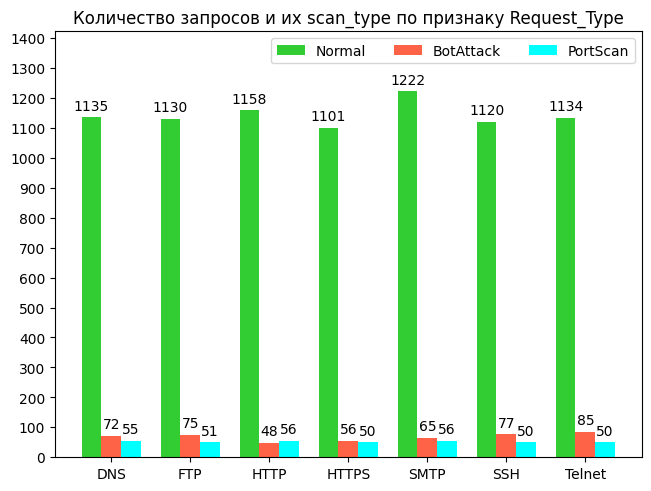

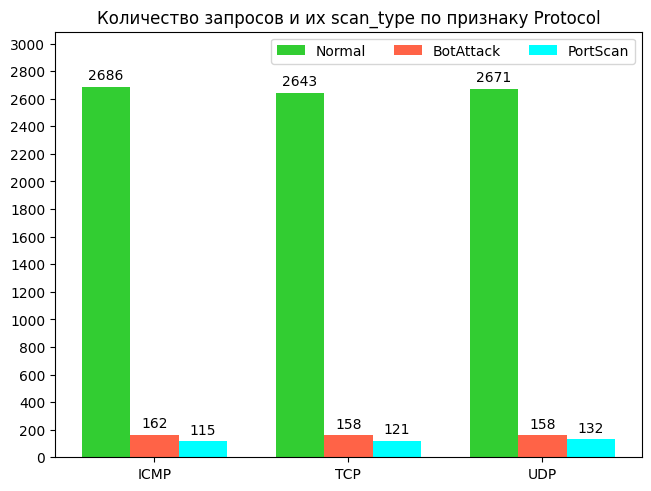

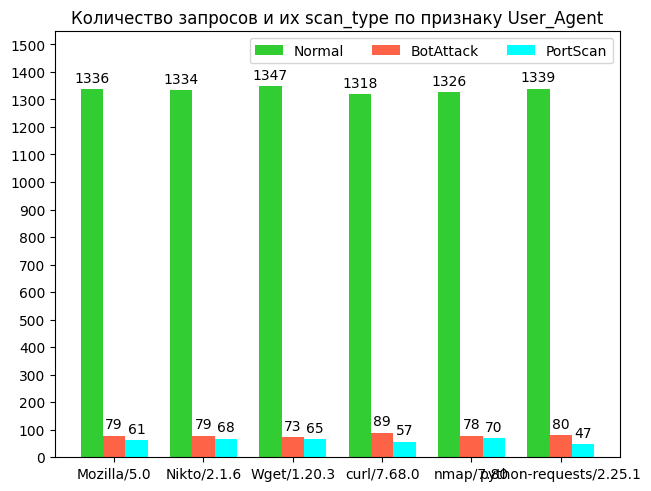

In [19]:
outcomes = ['Normal', 'BotAttack', 'PortScan']

for feature in list_of_features[1:]:
    request_by_scan_type, feature_labels = create_feature_dict(feature, outcomes) 
    create_bar_plot(request_by_scan_type, feature_labels, feature)

Все графики показывают приблизительно одинаковую картину: для всех признаков значение 'Normal' переменной Scan_Type имеет огромный перевес по сравнению со значениями 'BotAttack' и 'PortScan'. При этом все значения каждого признака находятся приблизительно на одном уровне для всех 'Normal' значений и 'BotAttack'/'PortScan'. Из этого следует вывод: **при Normal, BotAttack и PortScan нет явных фаворитов среди значений протоколов, портов и User-Agent'ов. Однако некоторые количественные отличия всё же присутствуют, поэтому данные признаки следует включить для обучения модели.**

### Проанализируем нагрузку

Построим гистограмму частот для визуализации размеров нагрузки с попытками вторжения.

Text(0, 0.5, 'Количество запросов')

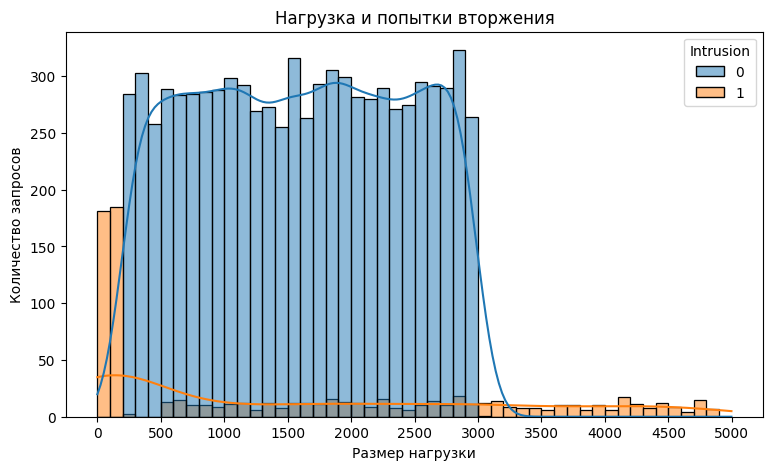

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

sns.histplot(data=logs, x='Payload_Size', hue='Intrusion', bins=np.arange(0, np.max(logs['Payload_Size']), 100), kde=True, ax=ax)
ax.set_title('Нагрузка и попытки вторжения')
ax.set_xticks(np.arange(0, 5100, 500))
ax.set_xlabel('Размер нагрузки')
ax.set_ylabel('Количество запросов')

Что мы можем видеть на гистограмме:
- больше всего попыток вторжений при малом (<200) и при большом (>3000) размере нагрузки;
- начиная со значения размера нагрузки в 3000 ед. все запросы являются вредоносными.

Построим гистограмму частот для визуализации размеров нагрузки с типом запроса. Что мы можем видеть на гистограмме:
- больше всего запросов с малой нагрузкой относятся к сканированию портов (корреляция с признаком вторжения);
- начиная со значения размера нагрузки в 3000 ед. все запросы относятся к бот-атаке (так же корреляция с признаком вторжения).

Text(0, 0.5, 'Количество запросов')

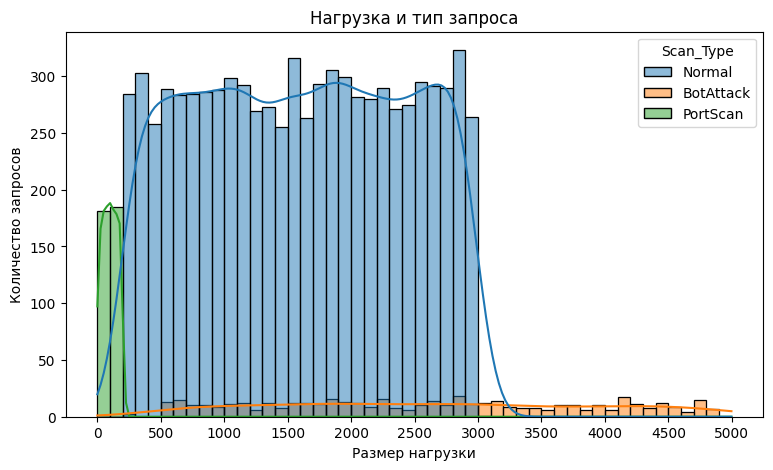

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

sns.histplot(data=logs, x='Payload_Size', hue='Scan_Type', bins=np.arange(0, np.max(logs['Payload_Size']), 100), kde=True, ax=ax)
ax.set_title('Нагрузка и тип запроса')
ax.set_xticks(np.arange(0, 5100, 500))
ax.set_xlabel('Размер нагрузки')
ax.set_ylabel('Количество запросов')

## Создание и преобразование признаков (Feature engineering)

На этапе разведочного анализа данных было принято решение взять в качестве признаков следующие столбцы: Port, Request_Type, Protocol, Payload_Size, User-Agent, Status. Удалим столбцы Source_IP и Destination_IP из датафрейма, т.к. они не несут практической пользы, а также столбец Intrusion, чтобы избежать таргетную утечку данных, т.к. признак Intrusion говорит о факте атаки.

Заодно приведем все категориальные столбцы к одному типу - object - для дальнейшего их кодирования.

In [19]:
logs.drop(['Source_IP', 'Destination_IP', 'Intrusion'], axis=1, inplace=True)
logs['Port'] = logs['Port'].astype('object')

In [20]:
print(logs.head(5))
print(logs.info())

  Port Request_Type Protocol  Payload_Size   User_Agent   Status  Scan_Type
0   80          FTP      UDP          2369  curl/7.68.0  Success     Normal
1  135         SMTP      UDP          1536  Wget/1.20.3  Failure  BotAttack
2   21         SMTP      TCP          1183  Wget/1.20.3  Success     Normal
3   25        HTTPS      TCP           666  Mozilla/5.0  Success     Normal
4   22          FTP      TCP          2821  Mozilla/5.0  Success     Normal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Port          8846 non-null   object
 1   Request_Type  8846 non-null   object
 2   Protocol      8846 non-null   object
 3   Payload_Size  8846 non-null   int64 
 4   User_Agent    8846 non-null   object
 5   Status        8846 non-null   object
 6   Scan_Type     8846 non-null   object
dtypes: int64(1), object(6)
memory usage: 483.9+ KB
None


Во избежание утечки данных через их предобработку разделим выборку на обучающую и тестовую.
При разделении выборки важно учесть выводы, сделанные на этапе EDA: данные не сбалансированы. Количество атак в выборке составляет чуть менее 10%, в то время как нормальных запросов 90%. Чтобы сохранить распределение классов необходимо использовать стратифицированную выборку.

In [21]:
X = logs.drop('Scan_Type', axis=1)
y = logs['Scan_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [22]:
print(f"Соотношение запросов по типу в тренировочном датасете в %:\n{y_train.value_counts().div(y_train.count()) * 100}")

Соотношение запросов по типу в тренировочном датасете в %:
Normal       90.439276
BotAttack     5.394057
PortScan      4.166667
Name: Scan_Type, dtype: float64


Выведем вспомогательную информацию для дальнейшей сверки.

In [23]:
X_train.head()

,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status
6201,21,DNS,UDP,1542,Nikto/2.1.6,Success
386,80,FTP,UDP,311,nmap/7.80,Success
6763,21,SSH,UDP,1579,curl/7.68.0,Success
8272,25,Telnet,ICMP,2178,nmap/7.80,Success
7671,25,HTTPS,ICMP,2188,python-requests/2.25.1,Success


In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6192 entries, 6201 to 3467
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Port          6192 non-null   object
 1   Request_Type  6192 non-null   object
 2   Protocol      6192 non-null   object
 3   Payload_Size  6192 non-null   int64 
 4   User_Agent    6192 non-null   object
 5   Status        6192 non-null   object
dtypes: int64(1), object(5)
memory usage: 338.6+ KB


## Логистическая регрессия
Преобразуем категориальные признаки для логистической регрессии. 

Для преобразования категориальных признаков необходимо посмотреть на их структуру:

- все категории не являются порядковыми, они представляют собой лишь названия (Протоколы/User-Agent'ы) или числовой идентификатор (Порты), следовательно нам не подойдёт Label Encodind, т.к. он вводит некоторую мнимую упорядоченность;
- для алгоритма логистической регрессии подойдёт One-Hot Encoding, т.к. все категориальные признаки кодируются в виде стобцов со значениями 0 (если значение не относится к столбцу) и 1 (если значение относится к столбцу). Однако данный encoder создаёт большое количество столбцов, в данном случае он создаст 28 новых столбцов. Тогда суммарное количество столбцов составит 30.

Закодируем категориальные столбцы Port, Request_Type, Protocol и User_Agent с помощью One-Hot Encoder'а, а для признака Status можно использовать Label Encoder, так как признак бинарный.

In [25]:
categorical_features = ['Port', 'Request_Type', 'Protocol', 'User_Agent']

# Инициализируем энкодер, sparse_output=False для получение матрицы
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Обучаем энкодер на тренировочном датасете и создаём матрицы закодированных признаков
X_train_cat = ohe_encoder.fit_transform(X_train[categorical_features]) 
X_test_cat = ohe_encoder.transform(X_test[categorical_features])  

# Преобразовываем полученные матрицы в датафреймы
X_train_cat_df = pd.DataFrame(
    X_train_cat, index=X_train.index, columns=ohe_encoder.get_feature_names_out(categorical_features)
)
X_test_cat_df = pd.DataFrame(
    X_test_cat, index=X_test.index, columns=ohe_encoder.get_feature_names_out(categorical_features)
)

# Объединяем исходный датафрейм и датафрейм закодированных признаков, удаляем старые столбцы
X_train = pd.concat([X_train, X_train_cat_df], axis=1)
X_train = X_train.drop(categorical_features, axis=1)

X_test = pd.concat([X_test, X_test_cat_df], axis=1)
X_test = X_test.drop(categorical_features, axis=1)

In [26]:
# Инициализируем энкодер
le_encoder = LabelEncoder()

# Кодируем статус
X_train['Status'] = le_encoder.fit_transform(X_train['Status'])
X_test['Status'] = le_encoder.transform(X_test['Status'])

### Преобразование числовых признаков
Нормализуем значения нагрузки с помощью StandardScaler.

In [27]:
# Инициализируем скелер
scaler = StandardScaler()

# Нормализуем признак нагрузки
X_train['Payload_Size'] = scaler.fit_transform(X_train[['Payload_Size']])
X_test['Payload_Size'] = scaler.transform(X_test[['Payload_Size']])

In [28]:
X_train.head()

,Payload_Size,Status,Port_21,Port_22,Port_23,Port_25,Port_53,Port_80,Port_135,Port_443,Port_4444,Port_6667,Port_8080,Port_31337,Request_Type_DNS,Request_Type_FTP,Request_Type_HTTP,Request_Type_HTTPS,Request_Type_SMTP,Request_Type_SSH,Request_Type_Telnet,Protocol_ICMP,Protocol_TCP,Protocol_UDP,User_Agent_Mozilla/5.0,User_Agent_Nikto/2.1.6,User_Agent_Wget/1.20.3,User_Agent_curl/7.68.0,User_Agent_nmap/7.80,User_Agent_python-requests/2.25.1
6201,-0.056298,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
386,-1.396757,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6763,-0.016008,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8272,0.636254,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7671,0.647143,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Для дальнейшего удобства создадим функции для преобразования количественных и качественных признаков.

In [22]:
def dataset_splitting(data):
    """Функция для разделения датасета на тренировочную и тестовую выборки"""
    
    columns_to_drop = ['Source_IP', 'Destination_IP', 'Intrusion']
    
    # Удаление лишних столбцов и приведение признака Port к типу object 
    data = data.drop(columns_to_drop, axis=1)
    data['Port'] = data['Port'].astype('object')
    
    X = data.drop('Scan_Type', axis=1)
    y = data['Scan_Type']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test


def categorical_data_preprocessing(X_train, X_test, y_train):
    categorical_features = ['Port', 'Request_Type', 'Protocol', 'User_Agent']

    # Инициализируем энкодер, sparse_output=False для получение матрицы
    ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Обучаем энкодер на тренировочном датасете и создаём матрицы закодированных признаков
    X_train_cat = ohe_encoder.fit_transform(X_train[categorical_features]) 
    X_test_cat = ohe_encoder.transform(X_test[categorical_features])
    
    # Преобразовываем полученные матрицы в датафреймы
    X_train_cat_df = pd.DataFrame(
        X_train_cat, index=X_train.index, columns=ohe_encoder.get_feature_names_out(categorical_features)
    )
    X_test_cat_df = pd.DataFrame(
        X_test_cat, index=X_test.index, columns=ohe_encoder.get_feature_names_out(categorical_features)
    )
    
    # Объединяем исходный датафрейм и датафрейм закодированных признаков, удаляем старые столбцы
    X_train = pd.concat([X_train, X_train_cat_df], axis=1)
    X_train = X_train.drop(categorical_features, axis=1)

    X_test = pd.concat([X_test, X_test_cat_df], axis=1)
    X_test = X_test.drop(categorical_features, axis=1)
    
    # Инициализируем энкодер
    le_encoder = LabelEncoder()

    # Кодируем статус
    X_train['Status'] = le_encoder.fit_transform(X_train['Status'])
    X_test['Status'] = le_encoder.transform(X_test['Status'])
    
    return X_train, X_test


def quantitive_data_preprocessing(X_train, X_test):
    """Функция для преобразования количественных признаков"""
    
    # Нормализация признака Payload_Size
    scaler = StandardScaler()

    X_train['Payload_Size'] = scaler.fit_transform(X_train[['Payload_Size']])
    X_test['Payload_Size'] = scaler.transform(X_test[['Payload_Size']])
    
    return X_train, X_test

In [23]:
X_train, X_test, y_train, y_test = dataset_splitting(logs)
X_train, X_test = categorical_data_preprocessing(X_train, X_test, y_train)  # Преобразование категориальных признаков
X_train, X_test = quantitive_data_preprocessing(X_train, X_test)  # Преобразование количественных признаков

In [24]:
X_train.head()

,Payload_Size,Status,Port_21,Port_22,Port_23,Port_25,Port_53,Port_80,Port_135,Port_443,Port_4444,Port_6667,Port_8080,Port_31337,Request_Type_DNS,Request_Type_FTP,Request_Type_HTTP,Request_Type_HTTPS,Request_Type_SMTP,Request_Type_SSH,Request_Type_Telnet,Protocol_ICMP,Protocol_TCP,Protocol_UDP,User_Agent_Mozilla/5.0,User_Agent_Nikto/2.1.6,User_Agent_Wget/1.20.3,User_Agent_curl/7.68.0,User_Agent_nmap/7.80,User_Agent_python-requests/2.25.1
6201,-0.056298,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
386,-1.396757,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6763,-0.016008,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8272,0.636254,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7671,0.647143,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Обучение модели мультиклассовой логистической регрессии

In [25]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
model.fit(X_train, y_train)

C:\python\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'multinomial'


In [26]:
y_pred = model.predict(X_test)

## Оценка эффективности модели
Выберем среди метрик качества моделей классификации наиболее подходящие:
- Accuracy (Общая точность) - доля правильных предсказаний среди всех наблюдений: (TP+TN)/(TP+FP+TN+FN). **В данном случае ориентироваться на Accuracy не стоит, т.к. имеется явный дисбаланс классов Normal и BotAttack/PortScan.**
- Precision (Точность) - доля правильно предсказанных положительных результатов среди всех положительных предсказаний: TP/(TP+FP). **В данном случае метрика Precision важна для определения истинных типов атак.**
- Recall (Плотность) - доля правильно предсказанных положительных результатов из всех фактически положительных: TP/(TP+FN). **В данном случае метрика Recall важна для охвата как можно большего количества вредоносных событий**
- F1-score - гармоническое среднее между precision и recall, обеспечивающее баланс между этими метриками: 2*(Precision\*Recall)/(Precision+Recall). **Так как важны и точность, и плотность при классификации, ориентиром будет метрика F1-Score**

**В данном случае приоритетной метрикой я считаю F1-Score, т.к. с точки зрения безопасности мы должны обнаружить и классифицировать все потенциальные атаки.Остальные метрики будут выведены для наглядности.**

In [27]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n")
print(f"{classification_report(y_test, y_pred)}")

Accuracy score: 0.9996232102486813

              precision    recall  f1-score   support

   BotAttack       1.00      0.99      1.00       144
      Normal       1.00      1.00      1.00      2400
    PortScan       0.99      1.00      1.00       110

    accuracy                           1.00      2654
   macro avg       1.00      1.00      1.00      2654
weighted avg       1.00      1.00      1.00      2654



Видно, что метрики эффективности модели имеют очень высокие значения - близко к единице. Выведем матрицу ошибок.

Text(0.5, 1.0, 'Confusion Matrix for Multiclass Logistic Regression')

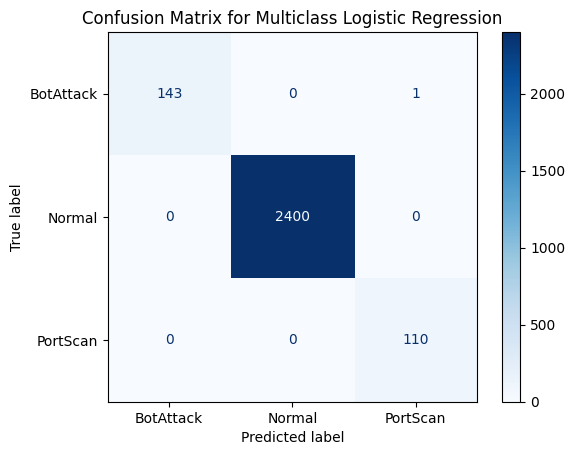

In [28]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix for Multiclass Logistic Regression')

На матрице ошибок видно, что среди всех предсказаний, только одно было классифицировано ошибочно. Такие показатели метрик модели могут говорить о переобучении, поэтому попробуем увеличить размер выборки и избавиться от дисбаланса классов с помощью SMOTE.

In [29]:
logs = pd.read_csv("Network_logs.csv")  # Повторная загрузка данных
X_train, X_test, y_train, y_test = dataset_splitting(logs)  # Разделение на тренировочную и тестовую выборки
X_train, X_test = categorical_data_preprocessing(X_train, X_test, y_train)  # Преобразование категориальных признаков
X_train, X_test = quantitive_data_preprocessing(X_train, X_test)  # Преобразование количественных признаков

In [30]:
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Выведем соотношение классов Scan_Type после применения SMOTE.

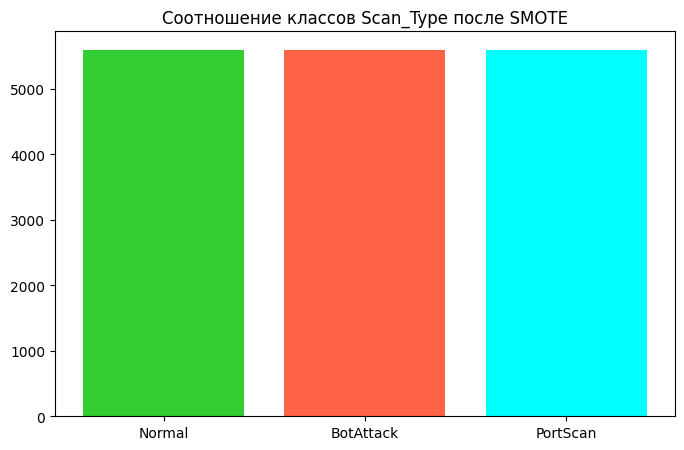

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.bar(y_train_smote.value_counts().index, y_train_smote.value_counts(), color=['limegreen', 'tomato', 'cyan'])
ax.set_title('Соотношение классов Scan_Type после SMOTE')
plt.show()

In [33]:
model2 = LogisticRegression()
model2.fit(X_train_smote, y_train_smote)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [34]:
y_pred2 = model2.predict(X_test)

In [35]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred2)}\n")
print(f"{classification_report(y_test, y_pred2)}")

Accuracy score: 0.9984928409947249

              precision    recall  f1-score   support

   BotAttack       1.00      1.00      1.00       144
      Normal       1.00      1.00      1.00      2400
    PortScan       0.96      1.00      0.98       110

    accuracy                           1.00      2654
   macro avg       0.99      1.00      0.99      2654
weighted avg       1.00      1.00      1.00      2654



Text(0.5, 1.0, 'Матрица ошибок модели после использования SMOTE')

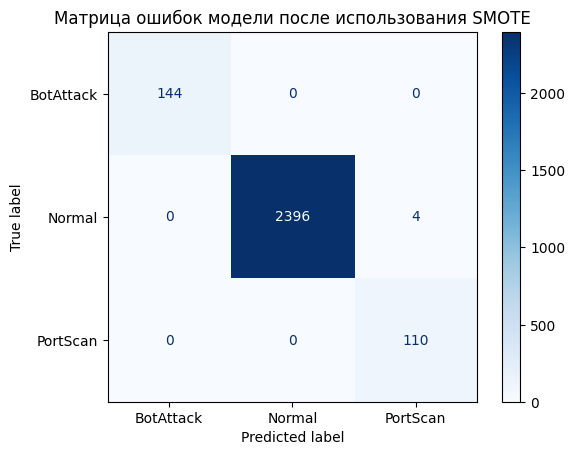

In [36]:
ConfusionMatrixDisplay.from_estimator(model2, X_test, y_test, cmap='Blues')
plt.title('Матрица ошибок модели после использования SMOTE')

На матрице ошибок видно, что после добавление новых данных и избавления от дисбаланса классов модель стала ошибаться чуть больше, но не сильно: имеется всего 4 ошибочных прогноза вместо 1.

## Вывод
Данная работа заключалась в классификации запросов в логах IDS на 3 класса: 
- Normal - обычные запросы;
- BotAttack - бот-атака;
- PortScan - сканирование портов.

Данные не нуждались в очистке, т.к. среди записей пропущенных значений не обнаружено, среди числовых переменных выбросов не наблюдалось.

На этапе разведочного анализа данных (EDA) выяснилось, что:
- Столбцы с IP-адресами отправителя/получателя не имеют практической ценности, т.к. их значение не говорит о характере запроса;
- Столбец Intrusion напрямую связан с целевой переменной Scan_Type, т.к. заранее классифицирует запросы на нормальные и вредоносные. Во избежание таргетной утечки данных параметр был удалён;
- Какого-либо перевеса портов, протоколов или User-Agent'ов при нормальных и вредоносных запросах не наблюдалось;
- Столбец с нагрузкой имел различия при нормальных и вредоносных запросах.

На этапе создания и преобразования признаков (Feature Engineering):
- Был выбран One-Hot-Encoder для кодирования признаков Port, Request_Type, Protocol и User-Agent, чтобы не вносить мнимый порядок, который может повлиять на качество модели;
- Был выбран LabelEncoder для кодирования признака Status, т.к. он является бинарным;
- Признак Payload_Size был нормализован с помощью StandardScaler.

В качестве алгоритма классификации в этой версии была выбрала логистическая регрессия. В рузельтате тестирования модели были получены следующие метрики:
- Accuracy: 0.99962 (Не ориентир из-за дисбаланса классов)
- Precision (macro avg): 1
- Recall (macro avg): 1
- F1-score (macro avg): 1

Высокие показатели метрик могут говорить о переобучении модели. Для того, чтобы получить более реальные показатели метрик я увеличил исходную выборку и убрал дисбаланс классов с помощью SMOTE. Однако метрики остались на том же высоком уровне. Из этого я делаю следующий вывод: **Хотя метрики модели классификации имеют высокие значения (модель не ошибается вовсе), нельзя говорить о безупречной работе модели в связи с малым количеством данных. Можно сказать, что модель хорошо обобщает текущие данные, однако использование реальных данных приведет к меньшим значениям метрик.**